<a href="https://colab.research.google.com/github/oo90x/ATM/blob/main/COCOCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train a model on top of the pretrained COCO 80 objects detection neural network model using transfer learning**

# Collecting data and Data cleaning

**Make directory to custom dataset**

In [1]:
!mkdir custom_dataset

Make train and validation folders in the prepared custom_dataset folder

In [2]:
!mkdir custom_dataset/train
!mkdir custom_dataset/train/images
!mkdir custom_dataset/train/labels
!mkdir custom_dataset/val
!mkdir custom_dataset/val/images
!mkdir custom_dataset/val/labels

**Create data.yaml file for YOLO**

In [3]:
yaml_text = """
train: /content/custom_dataset/train/images
val: /content/custom_dataset/val/images

nc: 83
names:
  - person
  - bicycle
  - car
  - motorcycle
  - airplane
  - bus
  - train
  - truck
  - boat
  - traffic light
  - fire hydrant
  - stop sign
  - parking meter
  - bench
  - bird
  - cat
  - dog
  - horse
  - sheep
  - cow
  - elephant
  - bear
  - zebra
  - giraffe
  - backpack
  - umbrella
  - handbag
  - tie
  - suitcase
  - frisbee
  - skis
  - snowboard
  - sports ball
  - kite
  - baseball bat
  - baseball glove
  - skateboard
  - surfboard
  - tennis racket
  - bottle
  - wine glass
  - cup
  - fork
  - knife
  - spoon
  - bowl
  - banana
  - apple
  - sandwich
  - orange
  - broccoli
  - carrot
  - hot dog
  - pizza
  - donut
  - cake
  - chair
  - couch
  - potted plant
  - bed
  - dining table
  - toilet
  - tv
  - laptop
  - mouse
  - remote
  - keyboard
  - cell phone
  - microwave
  - oven
  - toaster
  - sink
  - refrigerator
  - book
  - clock
  - vase
  - scissors
  - teddy bear
  - hair drier
  - toothbrush
  - pole
  - tree
  - sign
"""

with open("/content/data.yaml", "w") as f:
    f.write(yaml_text.strip())

print("✅ data.yaml created!")

✅ data.yaml created!


## Pole dataset

Upload pole dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Smart_cane.v7i.yolov8.zip to Smart_cane.v7i.yolov8.zip


Make temporary storage for cleaning the data

In [5]:
!mkdir temstorage

Unzip the data zip file inside temporary storage

In [6]:
!unzip /content/Smart_cane.v7i.yolov8.zip -d /content/temstorage/

Archive:  /content/Smart_cane.v7i.yolov8.zip
  inflating: /content/temstorage/README.dataset.txt  
  inflating: /content/temstorage/README.roboflow.txt  
  inflating: /content/temstorage/data.yaml  
   creating: /content/temstorage/test/
   creating: /content/temstorage/test/images/
 extracting: /content/temstorage/test/images/052_png.rf.29feaca308146647aad9f2a42cca8446.jpg  
 extracting: /content/temstorage/test/images/067_png.rf.bd55f9ac85a191f45467b084e8ce6459.jpg  
 extracting: /content/temstorage/test/images/096_png.rf.735ef6fec0dd10ebe22cf7898bec83a0.jpg  
 extracting: /content/temstorage/test/images/148G4QIDPDTY_jpg.rf.33ffde493668dc39c22340ef42945c3a.jpg  
 extracting: /content/temstorage/test/images/20220816_13_45_24_745_000_bfSm2U74UHdSXd2DG14bHRvOhhI2_F_3000_4000-1-_jpg.rf.4817b44b70e9ddc7486b494235c85cf3.jpg  
 extracting: /content/temstorage/test/images/20220817_13_21_03_991_000_XeILyNjOdiQqZqtvpFIXZVOifGr1_F_3264_2448_jpg.rf.3a6f9cb236243d573958715f8e2a4757.jpg  
 extract

Rename each file inside each folder to be 00 01 (should have been pole00 pole01 but anyway)

In [8]:
import os
from pathlib import Path

def rename_files_in_folder(folder_path, new_ext):
    folder = Path(folder_path)
    files = sorted(folder.glob(f'*.{new_ext}'))

    for i, file in enumerate(files):
        new_name = f"{i:02d}.{new_ext}"  # 2-digit names like 00, 01, 02
        file.rename(folder / new_name)

# 🔁 Folders to rename
paths = {
    "temstorage/train/images": "jpg",
    "temstorage/train/labels": "txt",
    "temstorage/test/images": "jpg",
    "temstorage/test/labels": "txt",
}

# ✨ Rename everything
for folder, ext in paths.items():
    rename_files_in_folder(folder, ext)

print("✅ All files renamed!")

✅ All files renamed!


Cleaning un-pole classes out

In [9]:
import os
from pathlib import Path

def keep_only_class(folder_labels, folder_images, target_class='2', image_ext='jpg'):
    label_dir = Path(folder_labels)
    image_dir = Path(folder_images)

    for label_file in label_dir.glob("*.txt"):
        # Read all lines in label file
        with open(label_file, 'r') as f:
            lines = f.readlines()

        # Check if any line starts with class 2
        has_class = any(line.strip().startswith(f"{target_class} ") for line in lines)

        if not has_class:
            # Delete label and corresponding image
            image_file = image_dir / f"{label_file.stem}.{image_ext}"
            print(f"❌ Removing {label_file.name} and {image_file.name}")
            label_file.unlink(missing_ok=True)
            image_file.unlink(missing_ok=True)

# 🧼 Clean both train and test folders
keep_only_class("temstorage/train/labels", "temstorage/train/images", target_class='2')
keep_only_class("temstorage/test/labels", "temstorage/test/images", target_class='2')

print("✅ Done! Only images with class 2 (pole) are kept.")

❌ Removing 168.txt and 168.jpg
❌ Removing 190.txt and 190.jpg
❌ Removing 163.txt and 163.jpg
❌ Removing 250.txt and 250.jpg
❌ Removing 172.txt and 172.jpg
❌ Removing 254.txt and 254.jpg
❌ Removing 157.txt and 157.jpg
❌ Removing 188.txt and 188.jpg
❌ Removing 187.txt and 187.jpg
❌ Removing 260.txt and 260.jpg
❌ Removing 194.txt and 194.jpg
❌ Removing 169.txt and 169.jpg
❌ Removing 182.txt and 182.jpg
❌ Removing 266.txt and 266.jpg
❌ Removing 156.txt and 156.jpg
❌ Removing 136.txt and 136.jpg
❌ Removing 174.txt and 174.jpg
❌ Removing 242.txt and 242.jpg
❌ Removing 243.txt and 243.jpg
❌ Removing 189.txt and 189.jpg
❌ Removing 185.txt and 185.jpg
❌ Removing 165.txt and 165.jpg
❌ Removing 245.txt and 245.jpg
❌ Removing 255.txt and 255.jpg
❌ Removing 195.txt and 195.jpg
❌ Removing 211.txt and 211.jpg
❌ Removing 148.txt and 148.jpg
❌ Removing 258.txt and 258.jpg
❌ Removing 256.txt and 256.jpg
❌ Removing 173.txt and 173.jpg
❌ Removing 07.txt and 07.jpg
❌ Removing 181.txt and 181.jpg
❌ Removing

Throw random pictures to check if its working

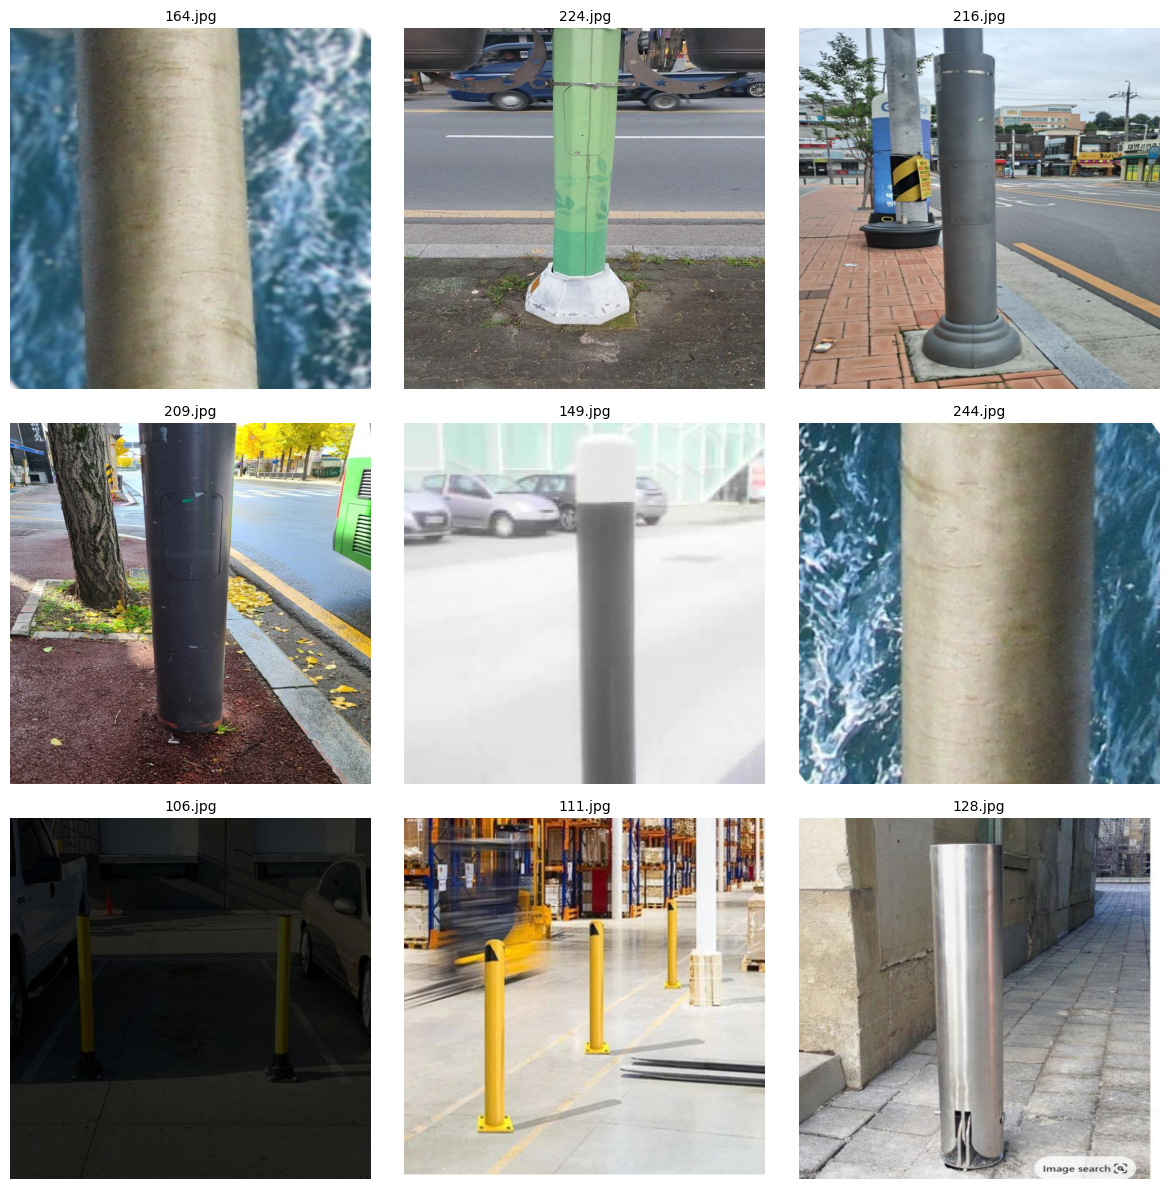

In [10]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def show_random_images(image_folder, n=9, image_ext='jpg'):
    image_paths = list(Path(image_folder).glob(f"*.{image_ext}"))
    selected = random.sample(image_paths, min(n, len(image_paths)))

    plt.figure(figsize=(12, 12))
    for i, img_path in enumerate(selected):
        img = Image.open(img_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(img_path.name, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 🔍 Visualize 9 random images from train folder
show_random_images("temstorage/train/images", image_ext='jpg')

Move the data into custom_dataset

In [11]:
import shutil
from pathlib import Path

# Define source and destination paths
source_train = Path("temstorage/train")
source_val = Path("temstorage/test")

dest_base = Path("custom_dataset")
dest_train_img = dest_base / "train/images"
dest_train_lbl = dest_base / "train/labels"
dest_val_img   = dest_base / "val/images"
dest_val_lbl   = dest_base / "val/labels"

# Make sure destination directories exist
for folder in [dest_train_img, dest_train_lbl, dest_val_img, dest_val_lbl]:
    folder.mkdir(parents=True, exist_ok=True)

# Move files from train
for file in (source_train / "images").glob("*"):
    shutil.move(str(file), dest_train_img / file.name)
for file in (source_train / "labels").glob("*"):
    shutil.move(str(file), dest_train_lbl / file.name)

# Move files from val (test)
for file in (source_val / "images").glob("*"):
    shutil.move(str(file), dest_val_img / file.name)
for file in (source_val / "labels").glob("*"):
    shutil.move(str(file), dest_val_lbl / file.name)

print("✅ Done! Files moved into 'custom_dataset' with proper structure.")

✅ Done! Files moved into 'custom_dataset' with proper structure.


Change class name to match the data.yaml file

In [12]:
from pathlib import Path

# Only remap class 2 → 76
OLD_CLASS = "2"
NEW_CLASS = "76"

# Directories to search
label_dirs = [
    Path("custom_dataset/train/labels"),
    Path("custom_dataset/val/labels")
]

for label_dir in label_dirs:
    for file in label_dir.glob("*.txt"):
        updated_lines = []
        with open(file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if parts and parts[0] == OLD_CLASS:
                    parts[0] = NEW_CLASS
                    updated_lines.append(" ".join(parts))
                else:
                    updated_lines.append(" ".join(parts))
        with open(file, "w") as f:
            f.write("\n".join(updated_lines) + "\n")

print("✅ All class '2' labels have been changed to '76'.")

✅ All class '2' labels have been changed to '76'.


## Tree dataset

Upload tree dataset

In [13]:
from google.colab import files
uploaded = files.upload()

Saving Tree dataset.v2i.yolov8.zip to Tree dataset.v2i.yolov8.zip


remove previous folder structure inside temstorage

In [14]:
!rm -rf temstorage/*

Unzip the data inside temstorage

In [15]:
!unzip /content/'Tree dataset.v2i.yolov8.zip' -d /content/temstorage/

Archive:  /content/Tree dataset.v2i.yolov8.zip
 extracting: /content/temstorage/README.dataset.txt  
 extracting: /content/temstorage/README.roboflow.txt  
 extracting: /content/temstorage/data.yaml  
   creating: /content/temstorage/train/
   creating: /content/temstorage/train/images/
 extracting: /content/temstorage/train/images/011214_jpg.rf.c64769ebcfd401d6ef475906d2aba2b4.jpg  
 extracting: /content/temstorage/train/images/011922_jpg.rf.b1808a8df56834f625a6c0154621d5d2.jpg  
 extracting: /content/temstorage/train/images/013165_jpg.rf.a9b897c2010e2cbade382e46ebabb622.jpg  
 extracting: /content/temstorage/train/images/161005_SCI_ginko-trees-jpg-CROP-promo-xlarge2_jpg.rf.a880010559a6e868fae5c7c54d54ca71.jpg  
 extracting: /content/temstorage/train/images/20230709_155319_jpg.rf.d8d445940fb12a69bbdd8964095c57ad.jpg  
 extracting: /content/temstorage/train/images/20230709_155323_jpg.rf.cc39d5b35ae7ff50e39dada099ba0f66.jpg  
 extracting: /content/temstorage/train/images/20230709_155326

Since this one lacks test set, we created one

In [16]:
!mkdir /content/temstorage/test
!mkdir /content/temstorage/test/images
!mkdir /content/temstorage/test/labels

Split the data in to train and test by 80/20

In [17]:
import os
import random
from pathlib import Path
import shutil

# Configuration
train_img_dir = Path("temstorage/train/images")
train_lbl_dir = Path("temstorage/train/labels")
test_img_dir = Path("temstorage/test/images")
test_lbl_dir = Path("temstorage/test/labels")
split_ratio = 0.2  # 20% for test

# Ensure test folders exist
test_img_dir.mkdir(parents=True, exist_ok=True)
test_lbl_dir.mkdir(parents=True, exist_ok=True)

# Get all image-label pairs
image_files = sorted(train_img_dir.glob("*"))
label_files = sorted(train_lbl_dir.glob("*"))

# Sanity check: match counts
assert len(image_files) == len(label_files), "Mismatch between image and label counts!"

# Randomly select indices to move
total = len(image_files)
num_to_move = int(total * split_ratio)
indices = random.sample(range(total), num_to_move)

# Move files
for i in indices:
    img_file = image_files[i]
    lbl_file = label_files[i]
    shutil.move(str(img_file), str(test_img_dir / img_file.name))
    shutil.move(str(lbl_file), str(test_lbl_dir / lbl_file.name))

print(f"✅ Moved {num_to_move} image-label pairs to test set.")


✅ Moved 42 image-label pairs to test set.


Rename all file to be tree00 tree01

In [18]:
from pathlib import Path

# Define all dirs
folders = {
    "train_images": Path("temstorage/train/images"),
    "train_labels": Path("temstorage/train/labels"),
    "test_images": Path("temstorage/test/images"),
    "test_labels": Path("temstorage/test/labels")
}

# Helper: rename files with shared prefix and incremental index
def rename_files(image_dir, label_dir, start_index=0, prefix="tree"):
    image_files = sorted(image_dir.glob("*"))
    label_files = sorted(label_dir.glob("*"))

    for i, (img, lbl) in enumerate(zip(image_files, label_files), start=start_index):
        new_base = f"{prefix}{i:02d}"
        img_ext = img.suffix
        new_img = image_dir / f"{new_base}{img_ext}"
        new_lbl = label_dir / f"{new_base}.txt"
        img.rename(new_img)
        lbl.rename(new_lbl)

    return start_index + len(image_files)

# First rename train set
next_index = rename_files(folders["train_images"], folders["train_labels"], start_index=0)

# Then continue with test set
rename_files(folders["test_images"], folders["test_labels"], start_index=next_index)

print("✅ All files renamed as tree00, tree01, ... across train and test folders.")

✅ All files renamed as tree00, tree01, ... across train and test folders.


Update the class to match the data.yaml

In [19]:
from pathlib import Path

def update_class_indices(label_dir, old_class, new_class):
    label_dir = Path(label_dir)
    for label_file in label_dir.glob("*.txt"):
        lines = []
        with label_file.open("r") as f:
            for line in f:
                parts = line.strip().split()
                if parts and parts[0] == str(old_class):
                    parts[0] = str(new_class)
                    lines.append(" ".join(parts))
        # Only overwrite if there was a match
        if lines:
            with label_file.open("w") as f:
                f.write("\n".join(lines) + "\n")

# Update train and test labels
update_class_indices("temstorage/train/labels", old_class=0, new_class=77)
update_class_indices("temstorage/test/labels", old_class=0, new_class=77)

print("✅ All label files updated: class 0 → 77")

✅ All label files updated: class 0 → 77


Move to custom_dataseet after cleaning

In [20]:
import shutil
from pathlib import Path

# Define source and destination directories
src_train_images = Path("temstorage/train/images")
src_train_labels = Path("temstorage/train/labels")
src_test_images = Path("temstorage/test/images")
src_test_labels = Path("temstorage/test/labels")

dst_train_images = Path("custom_dataset/train/images")
dst_train_labels = Path("custom_dataset/train/labels")
dst_val_images   = Path("custom_dataset/val/images")
dst_val_labels   = Path("custom_dataset/val/labels")

# Make sure destination folders exist
for folder in [dst_train_images, dst_train_labels, dst_val_images, dst_val_labels]:
    folder.mkdir(parents=True, exist_ok=True)

# Move training set
for img_file in src_train_images.glob("*.jpg"):
    shutil.move(str(img_file), dst_train_images / img_file.name)

for label_file in src_train_labels.glob("*.txt"):
    shutil.move(str(label_file), dst_train_labels / label_file.name)

# Move test set into val
for img_file in src_test_images.glob("*.jpg"):
    shutil.move(str(img_file), dst_val_images / img_file.name)

for label_file in src_test_labels.glob("*.txt"):
    shutil.move(str(label_file), dst_val_labels / label_file.name)

print("✅ All files moved into custom_dataset/train and custom_dataset/val")

✅ All files moved into custom_dataset/train and custom_dataset/val


## Signs dataset

Clear temstorage for next data

In [21]:
!rm -rf temstorage/*

(I discovered this data set with 4 diff classes of signs so it's better to extend the classes)

Update the data.yaml change the sign class to be 4 diff classes according to dataset

In [22]:
import yaml

# Path to your data.yaml
yaml_path = '/content/data.yaml'

# Load existing YAML
with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# Replace "sign" with specific sign types
new_classes = ['traffic light', 'stop', 'speedlimit', 'crosswalk']
if 'sign' in data['names']:
    index = data['names'].index('sign')
    data['names'].pop(index)
    for i, name in enumerate(new_classes):
        data['names'].insert(index + i, name)
    data['nc'] = len(data['names'])

# Save updated YAML
with open(yaml_path, 'w') as file:
    yaml.dump(data, file)

print("✅ data.yaml updated successfully!")

✅ data.yaml updated successfully!


Uploading sign dataset

In [23]:
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


Unzip the file inside the temstorage

In [24]:
!unzip /content/'archive (1).zip' -d /content/temstorage/

Archive:  /content/archive (1).zip
  inflating: /content/temstorage/annotations/road0.xml  
  inflating: /content/temstorage/annotations/road1.xml  
  inflating: /content/temstorage/annotations/road10.xml  
  inflating: /content/temstorage/annotations/road100.xml  
  inflating: /content/temstorage/annotations/road101.xml  
  inflating: /content/temstorage/annotations/road102.xml  
  inflating: /content/temstorage/annotations/road103.xml  
  inflating: /content/temstorage/annotations/road104.xml  
  inflating: /content/temstorage/annotations/road105.xml  
  inflating: /content/temstorage/annotations/road106.xml  
  inflating: /content/temstorage/annotations/road107.xml  
  inflating: /content/temstorage/annotations/road108.xml  
  inflating: /content/temstorage/annotations/road109.xml  
  inflating: /content/temstorage/annotations/road11.xml  
  inflating: /content/temstorage/annotations/road110.xml  
  inflating: /content/temstorage/annotations/road111.xml  
  inflating: /content/temst

In [25]:
!mkdir temstorage/labels

Rename class and match structure to YOLO

In [26]:
import xml.etree.ElementTree as ET
from pathlib import Path

# Define input/output directories
input_dir = Path("/content/temstorage/annotations")  # directory containing .xml files
output_dir = Path("/content/temstorage/labels")      # where YOLO .txt labels will go
output_dir.mkdir(parents=True, exist_ok=True)

# Define class mapping
class_map = {
    "trafficlight": 76,  # corresponds to 'traffic light'
    "stop": 77,          # corresponds to 'stop'
    "speedlimit": 78,    # corresponds to 'speedlimit'
    "crosswalk": 79      # corresponds to 'crosswalk'
}

# Convert each XML file
for xml_file in input_dir.glob("*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    img_width = int(root.find("size/width").text)
    img_height = int(root.find("size/height").text)

    yolo_labels = []

    for obj in root.findall("object"):
        cls = obj.find("name").text
        if cls not in class_map:
            continue  # skip unknown classes
        cls_id = class_map[cls]

        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Normalize
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        w = (xmax - xmin) / img_width
        h = (ymax - ymin) / img_height

        yolo_labels.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    # Write to .txt
    output_file = output_dir / f"{xml_file.stem}.txt"
    with open(output_file, "w") as f:
        f.write("\n".join(yolo_labels))

print("✅ Conversion complete. YOLO labels are in:", output_dir)

✅ Conversion complete. YOLO labels are in: /content/temstorage/labels


Rename into class00

In [27]:
import os
from collections import defaultdict

# Set your paths
image_dir = "temstorage/images"
label_dir = "temstorage/labels"

# Create a counter for each class
class_counters = defaultdict(int)

# Function to read class index from label file
def get_class_from_label(filepath):
    with open(filepath, 'r') as f:
        line = f.readline().strip()
        if line:
            return line.split()[0]  # class index
    return None

# Class index to name mapping (adjust to match your `data.yaml`)
class_map = {
    "76": "trafficlight",
    "77": "stop",
    "78": "speedlimit",
    "79": "crosswalk"
}

# Rename files
for filename in sorted(os.listdir(label_dir)):
    if filename.endswith(".txt"):
        label_path = os.path.join(label_dir, filename)
        class_id = get_class_from_label(label_path)
        if class_id in class_map:
            class_name = class_map[class_id]
            count = class_counters[class_name]
            new_name = f"{class_name}{count:02d}"

            # Original base name (without extension)
            base = os.path.splitext(filename)[0]

            # Old file paths
            old_label_path = os.path.join(label_dir, f"{base}.txt")
            old_image_path = os.path.join(image_dir, f"{base}.jpg")
            if not os.path.exists(old_image_path):  # try png if jpg not found
                old_image_path = os.path.join(image_dir, f"{base}.png")

            # New file paths
            new_label_path = os.path.join(label_dir, f"{new_name}.txt")
            new_image_path = os.path.join(image_dir, f"{new_name}.jpg")

            # Rename files
            os.rename(old_label_path, new_label_path)
            if os.path.exists(old_image_path):
                os.rename(old_image_path, new_image_path)

            # Increment counter
            class_counters[class_name] += 1

print("Renaming complete.")

Renaming complete.


Making proper folder structure preparing to move

In [28]:
!mkdir /content/temstorage/test
!mkdir /content/temstorage/test/images
!mkdir /content/temstorage/test/labels
!mkdir /content/temstorage/train
!mkdir /content/temstorage/train/images
!mkdir /content/temstorage/train/labels

Split 20/80 test train folders

In [29]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Paths
img_dir = "temstorage/images"
lbl_dir = "temstorage/labels"

train_img_dir = "temstorage/train/images"
train_lbl_dir = "temstorage/train/labels"
test_img_dir = "temstorage/test/images"
test_lbl_dir = "temstorage/test/labels"

# Create output directories
for path in [train_img_dir, train_lbl_dir, test_img_dir, test_lbl_dir]:
    os.makedirs(path, exist_ok=True)

# List all image files
image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

# Split
random.shuffle(image_files)
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
test_files = image_files[split_idx:]

# Function to move file pairs
def move_files(file_list, src_img, src_lbl, dst_img, dst_lbl):
    for file in file_list:
        label_file = os.path.splitext(file)[0] + ".txt"
        shutil.move(os.path.join(src_img, file), os.path.join(dst_img, file))
        if os.path.exists(os.path.join(src_lbl, label_file)):
            shutil.move(os.path.join(src_lbl, label_file), os.path.join(dst_lbl, label_file))

# Move files
move_files(train_files, img_dir, lbl_dir, train_img_dir, train_lbl_dir)
move_files(test_files, img_dir, lbl_dir, test_img_dir, test_lbl_dir)

print(f"Moved {len(train_files)} files to train and {len(test_files)} files to test.")

Moved 701 files to train and 176 files to test.


Move them to custom_dataset

In [30]:
import os
import shutil

# Define paths
src_train_img = 'temstorage/train/images'
src_train_lbl = 'temstorage/train/labels'
src_test_img = 'temstorage/test/images'
src_test_lbl = 'temstorage/test/labels'

dst_train_img = 'custom_dataset/train/images'
dst_train_lbl = 'custom_dataset/train/labels'
dst_val_img = 'custom_dataset/val/images'
dst_val_lbl = 'custom_dataset/val/labels'

# Make sure destination folders exist
os.makedirs(dst_train_img, exist_ok=True)
os.makedirs(dst_train_lbl, exist_ok=True)
os.makedirs(dst_val_img, exist_ok=True)
os.makedirs(dst_val_lbl, exist_ok=True)

# Move training data
for f in os.listdir(src_train_img):
    shutil.move(os.path.join(src_train_img, f), os.path.join(dst_train_img, f))
for f in os.listdir(src_train_lbl):
    shutil.move(os.path.join(src_train_lbl, f), os.path.join(dst_train_lbl, f))

# Move validation data
for f in os.listdir(src_test_img):
    shutil.move(os.path.join(src_test_img, f), os.path.join(dst_val_img, f))
for f in os.listdir(src_test_lbl):
    shutil.move(os.path.join(src_test_lbl, f), os.path.join(dst_val_lbl, f))

print("✅ All data moved to custom_dataset.")

✅ All data moved to custom_dataset.


# Training

## install ultralytics packages

In [31]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

## Choosing model

**model = yolov8n n=nano**

In [32]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 320MB/s]


## Train the model

**Training using 8 data loaders, 16 batch, freeze first 10 epochs, for total 50 epcohs**

In [33]:
model.train(
    data='/content/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    freeze=10,
    close_mosaic=10,
    name='yolo_fast_86cls',
    workers=8,
    device=0,
    cos_lr=True,
    amp=True
)

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolo_fast_86cls, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None

100%|██████████| 755k/755k [00:00<00:00, 104MB/s]

Overriding model.yaml nc=80 with nc=86

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,211,362 parameters, 3,211,346 gradients, 9.1 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'mode

100%|██████████| 5.35M/5.35M [00:00<00:00, 418MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 64.7±31.3 MB/s, size: 220.8 KB)


train: Scanning /content/custom_dataset/train/labels... 975 images, 0 backgrounds, 0 corrupt: 100%|██████████| 975/975 [00:02<00:00, 408.92it/s]

train: New cache created: /content/custom_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 71.9±76.0 MB/s, size: 161.1 KB)


val: Scanning /content/custom_dataset/val/labels... 231 images, 0 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<00:00, 395.15it/s]

val: New cache created: /content/custom_dataset/val/labels.cache


Plotting labels to runs/detect/yolo_fast_86cls/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo_fast_86cls
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.37G      1.061       5.17      1.253         45        640: 100%|██████████| 61/61 [00:22<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.60it/s]

                   all        231        406          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.14G      1.085      3.454      1.285         38        640: 100%|██████████| 61/61 [00:19<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]

                   all        231        406      0.649      0.445        0.4      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.16G      1.071      2.512      1.259         61        640: 100%|██████████| 61/61 [00:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        231        406      0.754      0.492      0.492      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.17G      1.085      2.035      1.247         54        640: 100%|██████████| 61/61 [00:17<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]


                   all        231        406      0.746      0.669      0.702      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.19G     0.9996      1.718      1.209         46        640: 100%|██████████| 61/61 [00:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        231        406      0.802      0.739      0.764      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.21G      1.005       1.67      1.215         49        640: 100%|██████████| 61/61 [00:18<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

                   all        231        406      0.831       0.73      0.768      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.22G     0.9741      1.529      1.193         56        640: 100%|██████████| 61/61 [00:17<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]

                   all        231        406      0.822      0.739      0.782       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.22G     0.9723      1.462      1.187         43        640: 100%|██████████| 61/61 [00:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

                   all        231        406      0.867      0.746      0.797      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.25G     0.9375       1.43      1.158         33        640: 100%|██████████| 61/61 [00:19<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

                   all        231        406      0.875      0.738      0.811      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.26G     0.9149      1.361      1.134         40        640: 100%|██████████| 61/61 [00:17<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

                   all        231        406      0.828       0.76      0.798        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.27G     0.9067       1.32      1.128         46        640: 100%|██████████| 61/61 [00:17<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

                   all        231        406      0.895      0.731      0.807      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.28G      0.926      1.321      1.144         34        640: 100%|██████████| 61/61 [00:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

                   all        231        406      0.908      0.755      0.829      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.3G     0.8733      1.276       1.14         56        640: 100%|██████████| 61/61 [00:18<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        231        406      0.878      0.774      0.819      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.31G     0.8692      1.242      1.114         64        640: 100%|██████████| 61/61 [00:17<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

                   all        231        406      0.856      0.784      0.824      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.33G     0.8526      1.221      1.118         23        640: 100%|██████████| 61/61 [00:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

                   all        231        406      0.847      0.783      0.828      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.33G     0.8706      1.199      1.118         74        640: 100%|██████████| 61/61 [00:18<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]

                   all        231        406      0.875      0.791      0.828      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.35G     0.8312      1.152      1.091         36        640: 100%|██████████| 61/61 [00:18<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

                   all        231        406       0.91      0.773      0.839       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.37G     0.8686      1.159      1.112         45        640: 100%|██████████| 61/61 [00:18<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        231        406      0.876       0.77      0.837      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.38G      0.844      1.141      1.099         59        640: 100%|██████████| 61/61 [00:18<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]

                   all        231        406      0.882      0.784      0.838      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.39G     0.8499      1.153      1.102         36        640: 100%|██████████| 61/61 [00:18<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

                   all        231        406      0.851      0.796      0.836       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.41G     0.8312      1.111      1.092         59        640: 100%|██████████| 61/61 [00:21<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

                   all        231        406      0.918      0.767      0.836      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.42G     0.8463      1.138      1.103         51        640: 100%|██████████| 61/61 [00:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

                   all        231        406      0.886      0.769       0.83      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.43G     0.8476      1.105      1.105         39        640: 100%|██████████| 61/61 [00:18<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

                   all        231        406      0.915      0.796      0.849      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.44G     0.8227      1.073      1.083         41        640: 100%|██████████| 61/61 [00:18<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        231        406      0.873      0.799      0.841      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.46G     0.8207       1.06      1.085         55        640: 100%|██████████| 61/61 [00:18<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

                   all        231        406       0.92      0.766      0.842      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.47G     0.8326      1.068       1.09         37        640: 100%|██████████| 61/61 [00:17<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

                   all        231        406      0.934      0.776      0.852      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.49G     0.8348       1.06      1.083         54        640: 100%|██████████| 61/61 [00:18<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.44it/s]

                   all        231        406      0.899      0.778      0.842      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.49G     0.8108      1.034      1.065         50        640: 100%|██████████| 61/61 [00:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

                   all        231        406      0.875      0.808       0.85      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.51G      0.831      1.054      1.086         57        640: 100%|██████████| 61/61 [00:18<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        231        406      0.895      0.807      0.855      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.53G     0.8019      1.018      1.073         55        640: 100%|██████████| 61/61 [00:17<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        231        406      0.911      0.788       0.85      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.54G     0.8058      1.032       1.08         68        640: 100%|██████████| 61/61 [00:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        231        406      0.922      0.778      0.843      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.55G     0.8048       1.01      1.068         39        640: 100%|██████████| 61/61 [00:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        231        406      0.941      0.777      0.847      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.57G     0.7824      1.004      1.067         47        640: 100%|██████████| 61/61 [00:19<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        231        406       0.89      0.782      0.847      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.58G     0.7687     0.9877      1.051         25        640: 100%|██████████| 61/61 [00:21<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        231        406      0.923       0.78      0.855      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.6G     0.7743     0.9822       1.06         42        640: 100%|██████████| 61/61 [00:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

                   all        231        406      0.892      0.799      0.854      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.6G     0.8101      1.022      1.082         57        640: 100%|██████████| 61/61 [00:19<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

                   all        231        406      0.929       0.79      0.854      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.62G     0.7959     0.9801      1.064         57        640: 100%|██████████| 61/61 [00:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

                   all        231        406      0.943      0.783      0.855      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.63G     0.8127     0.9785      1.077         40        640: 100%|██████████| 61/61 [00:17<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]

                   all        231        406      0.914      0.792      0.855      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.65G     0.7985      0.974      1.069         37        640: 100%|██████████| 61/61 [00:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        231        406      0.942      0.786      0.855       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.66G     0.7845     0.9663      1.065         33        640: 100%|██████████| 61/61 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

                   all        231        406      0.933      0.786      0.854       0.67


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.67G     0.7612      1.086       1.05         21        640: 100%|██████████| 61/61 [00:20<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]

                   all        231        406      0.923      0.776      0.852      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.69G     0.7285       1.06       1.04         23        640: 100%|██████████| 61/61 [00:17<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        231        406      0.916      0.783      0.853       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.7G     0.7269      1.047      1.038         25        640: 100%|██████████| 61/61 [00:18<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

                   all        231        406      0.916      0.793      0.854      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.71G     0.7323      1.042      1.048         29        640: 100%|██████████| 61/61 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        231        406      0.914      0.792      0.855      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.73G     0.7265      1.032      1.033         19        640: 100%|██████████| 61/61 [00:17<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        231        406       0.92      0.794      0.856      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.75G     0.7241      1.045      1.036         19        640: 100%|██████████| 61/61 [00:18<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


                   all        231        406      0.918      0.796      0.857      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.76G      0.735      1.043      1.048         19        640: 100%|██████████| 61/61 [00:18<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]

                   all        231        406      0.914      0.795      0.856      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.76G     0.7312      1.038      1.035         23        640: 100%|██████████| 61/61 [00:17<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        231        406       0.92      0.784      0.859      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.78G     0.7174      1.025      1.033         39        640: 100%|██████████| 61/61 [00:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


                   all        231        406      0.923      0.785      0.859      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.8G     0.7254      1.031      1.033         27        640: 100%|██████████| 61/61 [00:18<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

                   all        231        406       0.92      0.782      0.858      0.668



50 epochs completed in 0.310 hours.
Optimizer stripped from runs/detect/yolo_fast_86cls/weights/last.pt, 6.6MB
Optimizer stripped from runs/detect/yolo_fast_86cls/weights/best.pt, 6.6MB

Validating runs/detect/yolo_fast_86cls/weights/best.pt...
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,206,030 parameters, 0 gradients, 9.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


                   all        231        406      0.928       0.79      0.854      0.671
              scissors         40         71      0.888      0.732      0.847      0.582
            teddy bear         60        152      0.859      0.447      0.592      0.367
            hair drier        131        149      0.993      0.986      0.991      0.903
            toothbrush         30         34      0.971      0.993      0.986      0.832
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/detect/yolo_fast_86cls


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([76, 77, 78, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ad42b81c590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

**Download the model file**

In [36]:
!rm -rf /root/.config/Google

In [45]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
!cp /content/runs/detect/yolo_fast_86cls/weights/best.pt /content/drive/MyDrive/deepATMv2.pt

In [47]:
!zip -r runs_backup_deepATMv2.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/yolo_fast_86cls/ (stored 0%)
  adding: runs/detect/yolo_fast_86cls/val_batch2_pred.jpg (deflated 7%)
  adding: runs/detect/yolo_fast_86cls/labels_correlogram.jpg (deflated 38%)
  adding: runs/detect/yolo_fast_86cls/results.csv (deflated 62%)
  adding: runs/detect/yolo_fast_86cls/PR_curve.png (deflated 13%)
  adding: runs/detect/yolo_fast_86cls/val_batch0_pred.jpg (deflated 16%)
  adding: runs/detect/yolo_fast_86cls/confusion_matrix_normalized.png (deflated 16%)
  adding: runs/detect/yolo_fast_86cls/val_batch2_labels.jpg (deflated 7%)
  adding: runs/detect/yolo_fast_86cls/train_batch2442.jpg (deflated 8%)
  adding: runs/detect/yolo_fast_86cls/weights/ (stored 0%)
  adding: runs/detect/yolo_fast_86cls/weights/best.pt (deflated 9%)
  adding: runs/detect/yolo_fast_86cls/weights/last.pt (deflated 9%)
  adding: runs/detect/yolo_fast_86cls/train_batch1.jpg (deflated 4%)
  adding: runs/detect/yolo_fast_86cls/v

In [48]:
from google.colab import files
files.download('runs_backup_deepATMv2.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
import shutil
import os

# Set destination path in Google Drive
drive_path = '/content/drive/MyDrive/yolo_training_runs'
os.makedirs(drive_path, exist_ok=True)

# Zip the runs/ folder
shutil.make_archive('runs_backup_deepATMv2', 'zip', 'runs')

# Move the zipped file to Google Drive
shutil.move('runs_backup_deepATMv2.zip', f'{drive_path}/runs_backup_deepATMv2.zip')

print(f'✅ Zipped runs/ folder saved to: {drive_path}/runs_backup_deepATMv2.zip')

In [61]:
from google.colab import files
import shutil

# Define original and new model paths
original_path = 'runs/detect/yolo_fast_86cls/weights/best.pt'
renamed_path = 'deepATMv2.pt'

# Copy and rename the file
shutil.copy(original_path, renamed_path)

# Download the renamed model
files.download(renamed_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Training metric

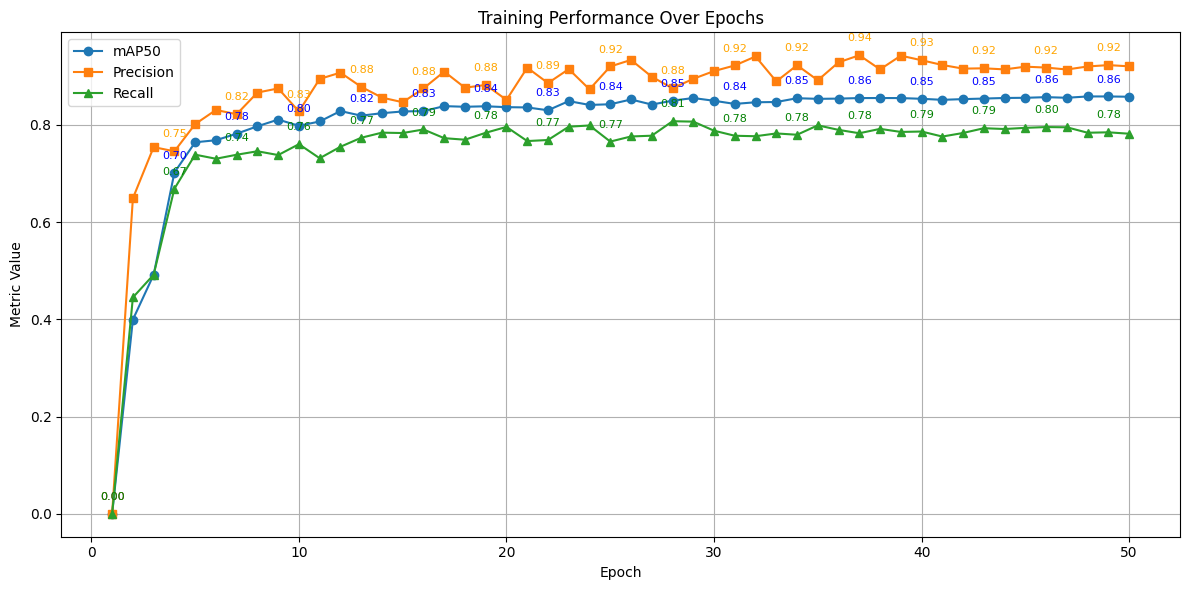

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved results.csv
df = pd.read_csv('runs/detect/yolo_fast_86cls/results.csv')

# Plot mAP50, precision, and recall over epochs
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', marker='o')
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', marker='s')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', marker='^')

# Annotate values every 5 epochs
for i in range(0, len(df), 3):
    x = df['epoch'][i]
    plt.annotate(f"{df['metrics/mAP50(B)'][i]:.2f}", (x, df['metrics/mAP50(B)'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='blue')
    plt.annotate(f"{df['metrics/precision(B)'][i]:.2f}", (x, df['metrics/precision(B)'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='orange')
    plt.annotate(f"{df['metrics/recall(B)'][i]:.2f}", (x, df['metrics/recall(B)'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')

# Styling
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Training Performance Over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

### Loss curve

In [53]:
import pandas as pd

# Load CSV and print columns
df = pd.read_csv('runs/detect/yolo_fast_86cls/results.csv')
print("Available columns:\n", df.columns.tolist())

Available columns:
 ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


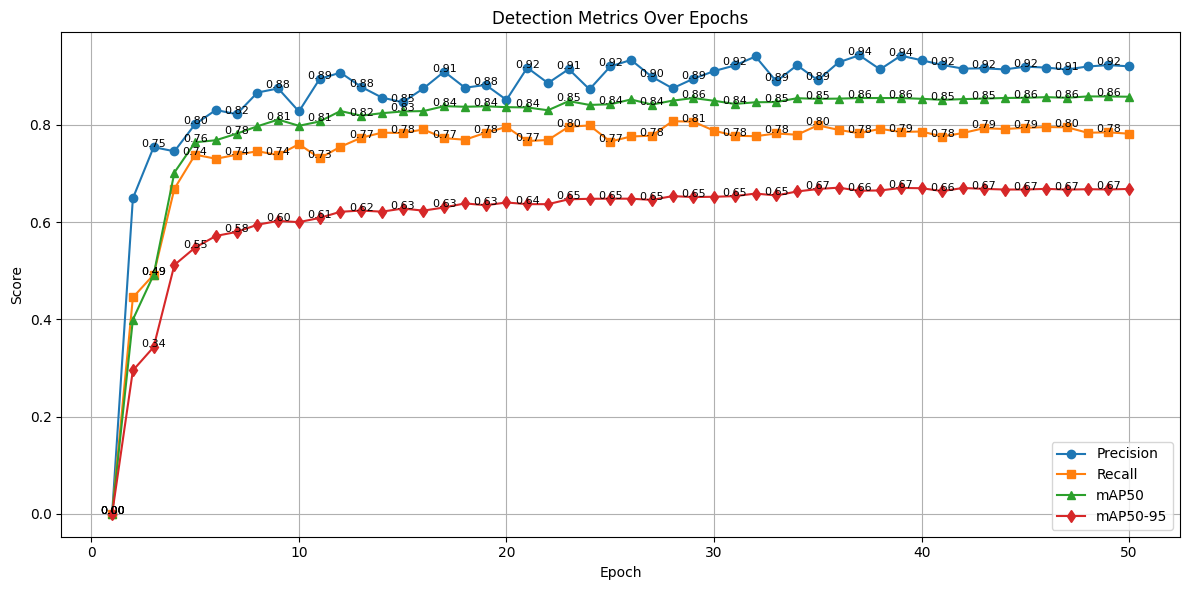

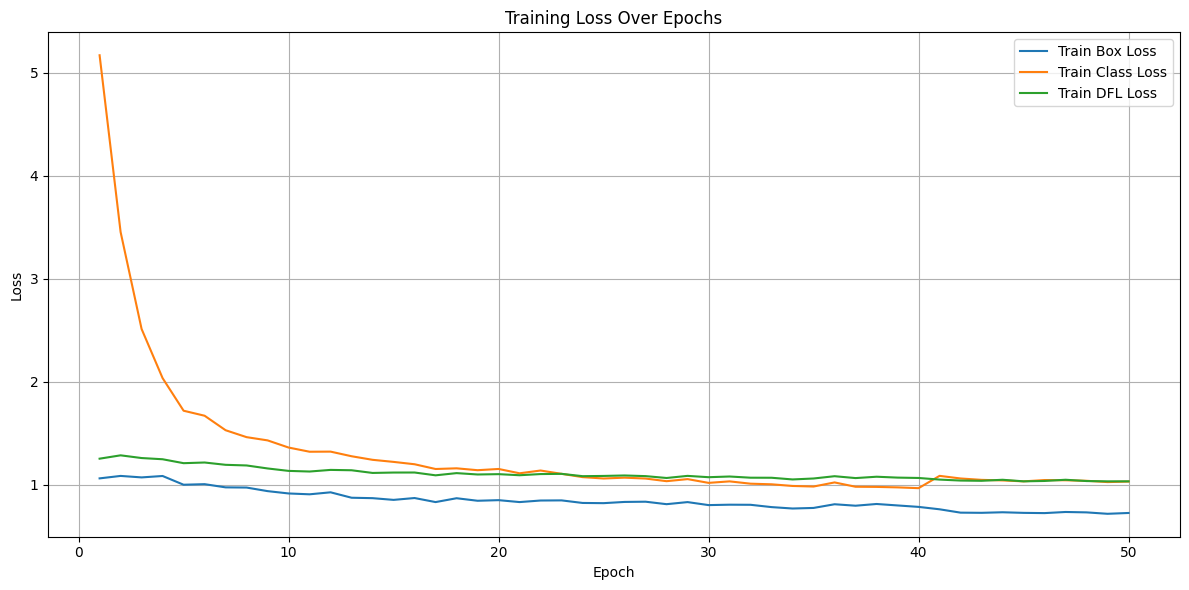

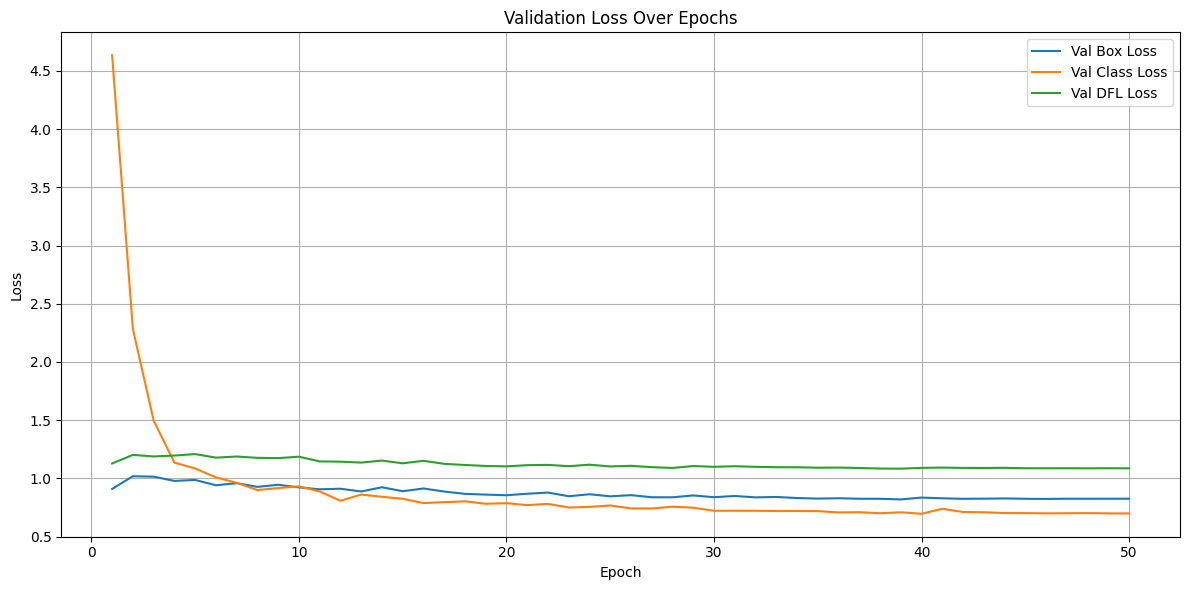

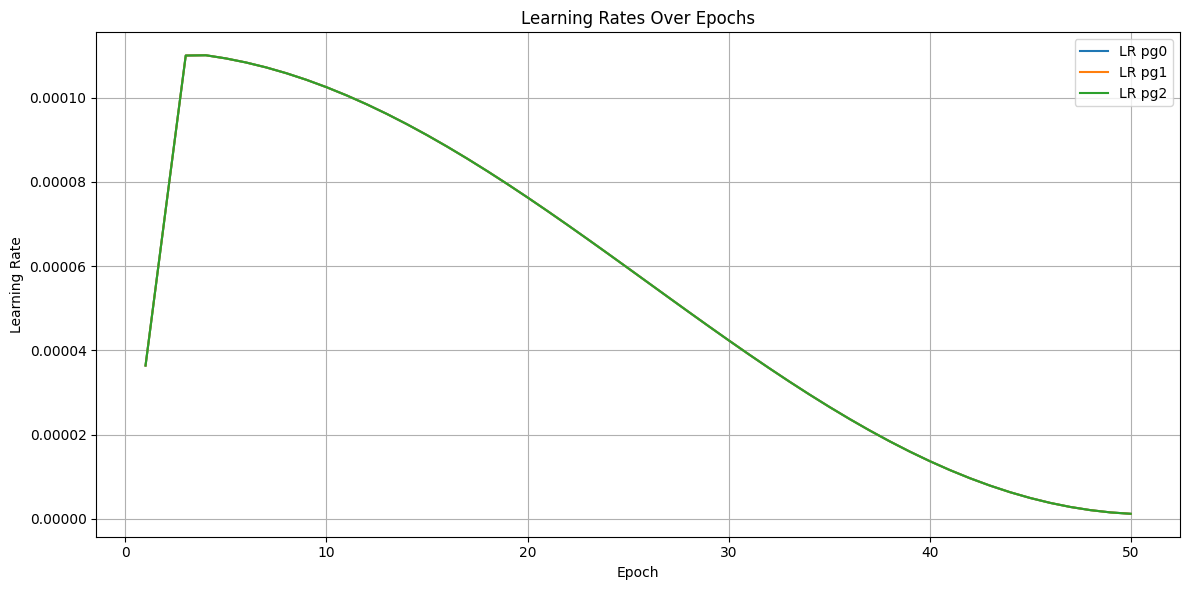

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results
df = pd.read_csv('runs/detect/yolo_fast_86cls/results.csv')

# --- Plot 1: Metrics over epochs ---
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', marker='o')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', marker='s')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', marker='^')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', marker='d')

# Annotate every 5 epochs
for i in range(0, len(df), 2):
    plt.text(df['epoch'][i], df['metrics/mAP50(B)'][i], f"{df['metrics/mAP50(B)'][i]:.2f}", fontsize=8, ha='center')
    plt.text(df['epoch'][i], df['metrics/recall(B)'][i], f"{df['metrics/recall(B)'][i]:.2f}", fontsize=8, ha='center')
    plt.text(df['epoch'][i], df['metrics/precision(B)'][i], f"{df['metrics/precision(B)'][i]:.2f}", fontsize=8, ha='center')
    plt.text(df['epoch'][i], df['metrics/mAP50-95(B)'][i], f"{df['metrics/mAP50-95(B)'][i]:.2f}", fontsize=8, ha='center')

plt.title('Detection Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Training Losses ---
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')

plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Validation Losses ---
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')

plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 4: Learning Rates ---
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['lr/pg0'], label='LR pg0')
plt.plot(df['epoch'], df['lr/pg1'], label='LR pg1')
plt.plot(df['epoch'], df['lr/pg2'], label='LR pg2')

plt.title('Learning Rates Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

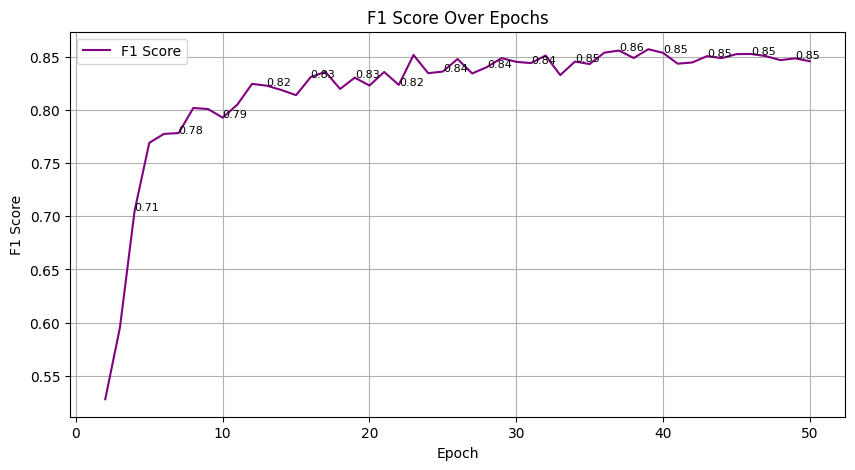

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('runs/detect/yolo_fast_86cls/results.csv')

# Calculate F1 for each epoch
df['f1_score'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / \
                 (df['metrics/precision(B)'] + df['metrics/recall(B)'])

# Plot F1 score
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['f1_score'], label='F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.grid(True)
plt.legend()

# Annotate every 5th epoch
for i in range(0, len(df), 3):
    plt.text(df['epoch'][i], df['f1_score'][i], f"{df['f1_score'][i]:.2f}", fontsize=8)

plt.show()

In [60]:
import pandas as pd

# Load the results.csv file
df = pd.read_csv('runs/detect/yolo_fast_86cls/results.csv')

# Compute F1 score
df['f1_score'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / \
                 (df['metrics/precision(B)'] + df['metrics/recall(B)'])

# Select relevant columns for evaluation
eval_df = df[[
    'epoch',
    'metrics/precision(B)',
    'metrics/recall(B)',
    'metrics/mAP50(B)',
    'metrics/mAP50-95(B)',
    'f1_score',
    'val/box_loss',
    'val/cls_loss',
    'val/dfl_loss'
]]

# Round the values for readability
eval_df = eval_df.round(4)

# Display the full evaluation table
print(eval_df.tail(10))  # Show last 10 epochs as example


    epoch  metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
40     41                0.9233             0.7760            0.8516   
41     42                0.9158             0.7834            0.8531   
42     43                0.9164             0.7932            0.8542   
43     44                0.9142             0.7916            0.8554   
44     45                0.9198             0.7940            0.8558   
45     46                0.9179             0.7956            0.8571   
46     47                0.9140             0.7951            0.8558   
47     48                0.9202             0.7839            0.8586   
48     49                0.9230             0.7848            0.8585   
49     50                0.9205             0.7819            0.8580   

    metrics/mAP50-95(B)  f1_score  val/box_loss  val/cls_loss  val/dfl_loss  
40               0.6639    0.8433        0.8290        0.7388        1.0928  
41               0.6702    0.8444        0.8246    